In [1]:
import os
import sys

# Add the project root to the system path

# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Navigate to the project root (adjust number of ".." as needed)
project_root = os.path.abspath(os.path.join(notebook_dir, "../"))
print(project_root)

# Add the project root to the system path
if project_root not in sys.path:
    sys.path.append(project_root)

from src.utils.figures import *
import pandas as pd
import re

/Users/annaboser/Documents/GitHub/smallholder-irrigation-dataset


In [2]:
# Read in and merge all data in the merged folder
merged_folder = "../data/labels/labeled_surveys/random_sample/merged"
files = os.listdir(merged_folder)

# Assuming the files are CSVs, read and merge them into a single DataFrame
df = pd.concat([pd.read_csv(os.path.join(merged_folder, file)) for file in files if file.endswith('.csv')], ignore_index=True)
df

,site_id,internal_id,plot_file,operator,operator_initials,x,y,water_source,image_number,year,...,day,irrigation,percent_coverage,coverage_outlier,percent_coverage_high_certainty,poly_avg_size,poly_avg_size_high_certainty,poly_min_size,poly_min_size_high_certainty,source_file
0,id_5170792,8,Zambia_0.05_n_225-249.csv,NaN,DSB,23.460475,-15.076142,False,1,2019,...,10,1,0.000000,False,0.000000,NaN,NaN,NaN,NaN,DSB_225-249
1,id_5154963,9,Zambia_0.05_n_225-249.csv,NaN,DSB,27.607460,-14.696160,False,1,2018,...,29,1,0.000000,False,0.000000,NaN,NaN,NaN,NaN,DSB_225-249
2,id_5154963,9,Zambia_0.05_n_225-249.csv,NaN,DSB,27.607460,-14.696160,False,2,2018,...,26,1,0.000000,False,0.000000,NaN,NaN,NaN,NaN,DSB_225-249
3,id_5154963,9,Zambia_0.05_n_225-249.csv,NaN,DSB,27.607460,-14.696160,False,3,2017,...,11,1,0.000000,False,0.000000,NaN,NaN,NaN,NaN,DSB_225-249
4,id_5154963,9,Zambia_0.05_n_225-249.csv,NaN,DSB,27.607460,-14.696160,False,4,2017,...,17,1,0.000000,False,0.000000,NaN,NaN,NaN,NaN,DSB_225-249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2994,id_1032067,25,Zambia_0.05_n_101-125.csv,NaN,MV,31.403282,-8.874727,True,1,2024,...,11,1,0.000000,False,0.000000,NaN,NaN,NaN,NaN,MV_JL_101-125
2995,id_5062566,21,Zambia_0.05_n_101-125.csv,NaN,MV,28.862556,-11.155457,False,1,2024,...,27,1,0.000000,False,0.000000,NaN,NaN,NaN,NaN,MV_JL_101-125
2996,id_5062566,21,Zambia_0.05_n_101-125.csv,NaN,MV,28.862556,-11.155457,False,2,2019,...,14,4,0.049521,False,0.049521,495.317096,495.317096,495.317096,495.317096,MV_JL_101-125
2997,id_5063118,20,Zambia_0.05_n_101-125.csv,NaN,MV,29.970006,-11.173630,False,1,2024,...,11,1,0.000000,False,0.000000,NaN,NaN,NaN,NaN,MV_JL_101-125


In [3]:
# Add a column that indicates if this is a v2 survey based on the soruce file name

df['v2'] = df['source_file'].apply(lambda x: 1 if re.search(r'v2', x) else 0)

# Add a column that indicates if this is a survey that has been corrected

df['corrected'] = df['source_file'].apply(lambda x: 1 if re.match(r'^[A-Z]+_[A-Z]+_', x) else 0)

# Mark the most up to date responses (source_file) for each survey (plot_file)

# Make a list of all the survey files
survey_files = df['plot_file'].unique()

# Make a list of source files that are most recent
most_recent_source = []

# For each survey file, list out the unique associated source files and find the one that is most recent. 
# If there are any corrected v2, they are the most recent
# In not but there is are corrected surveys, those are the most recent
# If not but there are uncorrected v2, those are the most recent
# Otherwise, it's just whatever is left over

for survey_file in survey_files:
    source_files = df[df['plot_file'] == survey_file]['source_file'].unique().tolist()
    
    # Priority order: corrected v2 > corrected (not v2) > uncorrected v2 > others
    corrected_v2 = [s for s in source_files if re.match(r'^[A-Z]+_[A-Z]+_v2', s)]
    corrected = [s for s in source_files if re.match(r'^[A-Z]+_[A-Z]+_', s) and 'v2' not in s]
    uncorrected_v2 = [s for s in source_files if re.match(r'^[A-Z]+_v2', s)]
    
    if corrected_v2:
        most_recent_source.append(corrected_v2) 
    elif corrected:
        most_recent_source.append(corrected)
    elif uncorrected_v2:
        most_recent_source.append(uncorrected_v2)
    elif source_files:
        most_recent_source.append(source_files)
    else:
        most_recent_source.append(None)  # or handle this case as needed

# Add a column to the dataframe that indicates if this is the most recent source file
df['most_recent'] = df.apply(lambda x: 1 if x['source_file'] in most_recent_source[survey_files.tolist().index(x['plot_file'])] else 0, axis=1)

# Manually add AB_JL_101-125 as a most recent survey
df.loc[df['source_file'] == 'AB_JL_101-125', 'most_recent'] = 1

# Progress statistics

In [4]:
# List out any source file that are the most recent but are not v2
most_recent_not_v2 = df[(df['most_recent'] == 1) & (df['v2'] == 0)]['source_file'].unique()
most_recent_v2 = df[(df['most_recent'] == 1) & (df['v2'] == 1)]['source_file'].unique()
not_most_recent_v2 = df[(df['most_recent'] == 0) & (df['v2'] == 1)]['source_file'].unique()

print("Most recent source files that are not v2:")
for file in most_recent_not_v2:
    print(file)
print("Most recent source files that are v2:")
for file in most_recent_v2:
    print(file)
print("Not most recent source files that are v2:")
for file in not_most_recent_v2:
    print(file)

Most recent source files that are not v2:
KL_474-498
JL_400-424
AB_JL_101-125
JL_375-399
MV_76-100
KL_300-324
Most recent source files that are v2:
JL_KL_v2_101-125
KL_DSB_v2_101-125
DSB_MV_v2_101-125
KL_MV_v2_176-200
MV_v2_275-299
MV_DSB_v2_1-25
KL_v2_51-75
JL_v2_151-175
JL_DSB_v2_126-150
DSB_v2_350-374
MV_JL_v2_101-125
DSB_v2_325-349
MV_v2_449-473
JL_v2_250-274
DSB_v2_225-249
MV_v2_425-449
KL_v2_201-225
DSB_JL_v2_26-50
Not most recent source files that are v2:
MV_v2_101-125
JL_v2_101-125
JL_v2_26-50


In [5]:
# Some statistics on only the most recent surveys
most_recent_surveys = df[df['most_recent'] == 1]

# Remove 'MV_76-100'
most_recent_surveys = most_recent_surveys[~most_recent_surveys['source_file'].str.contains('MV_76-100')]

label_count_table(most_recent_surveys)

,AB,DSB,JL,KL,MV,Total (unique),Total (not unique)
Surveys,1,5,6,6,5,19,23
Locations,21,114,141,128,120,438,524
Images,51,286,349,324,300,1110,1310


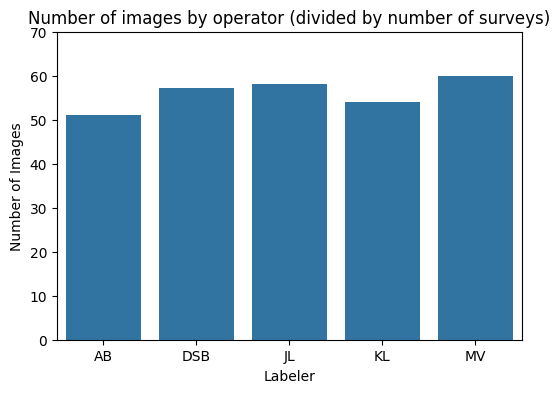

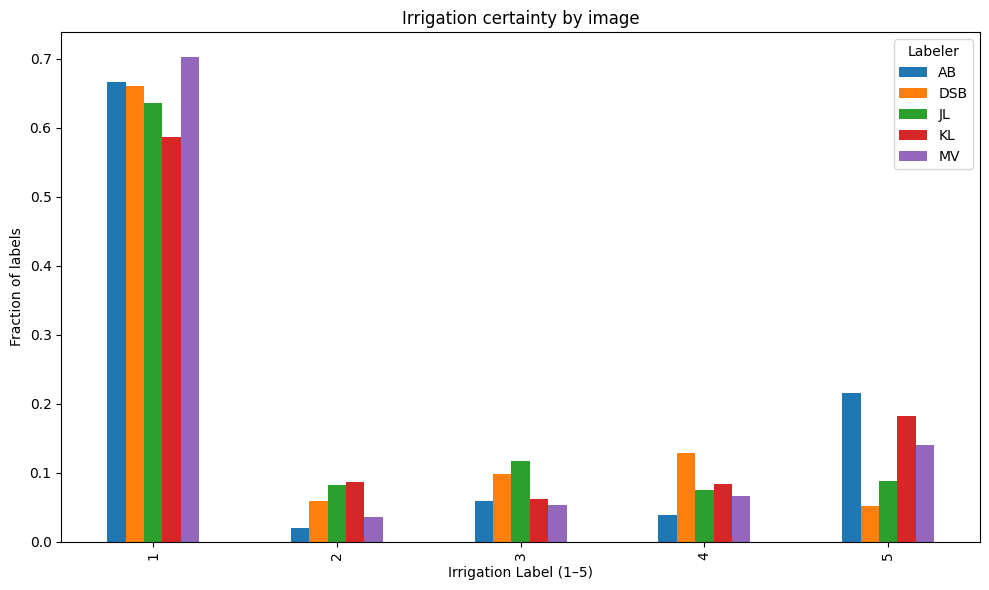

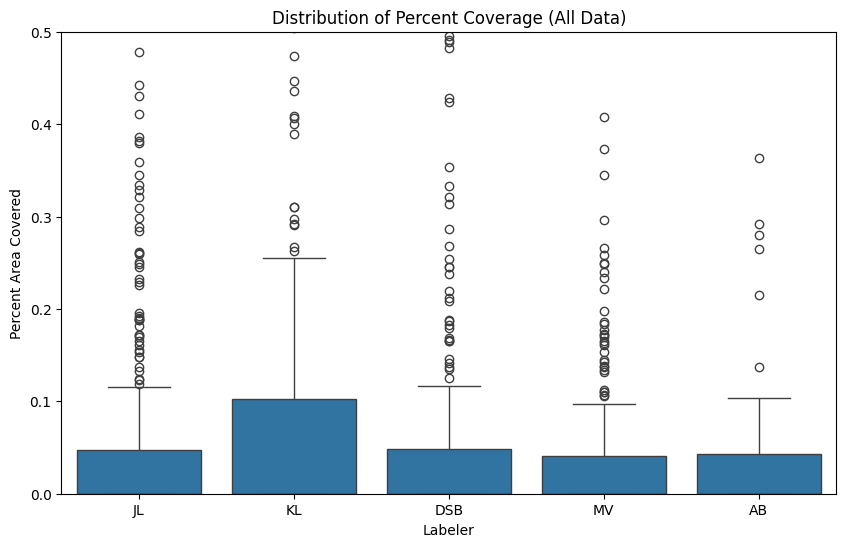

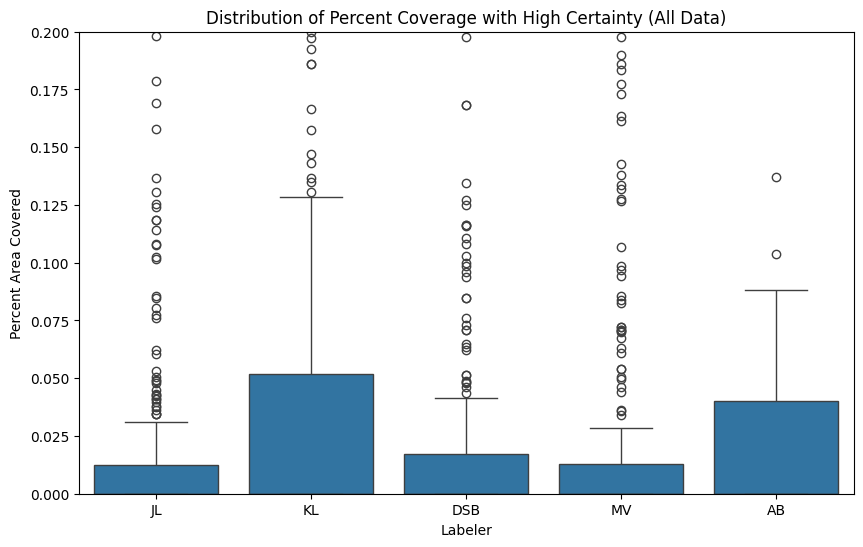

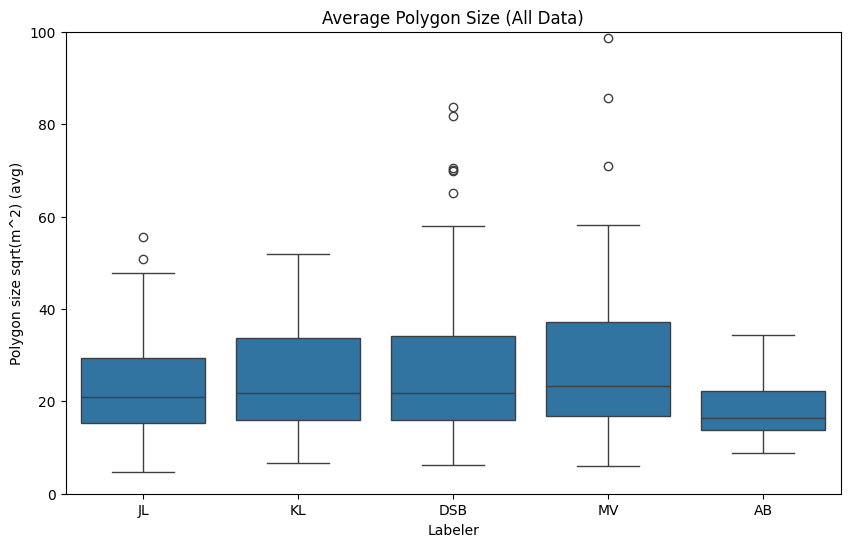

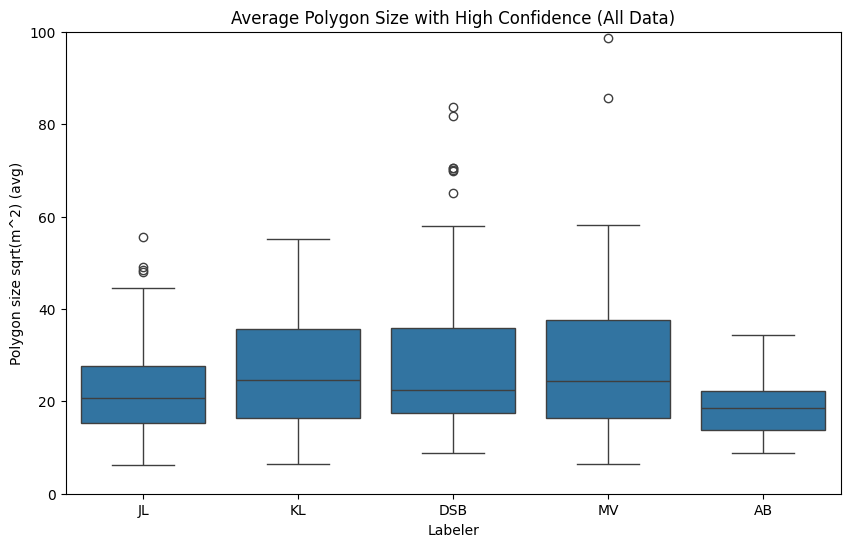

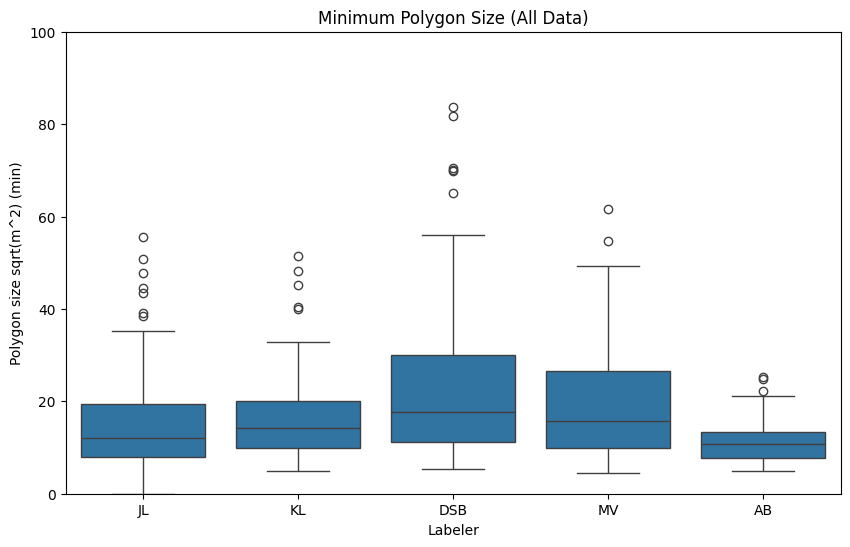

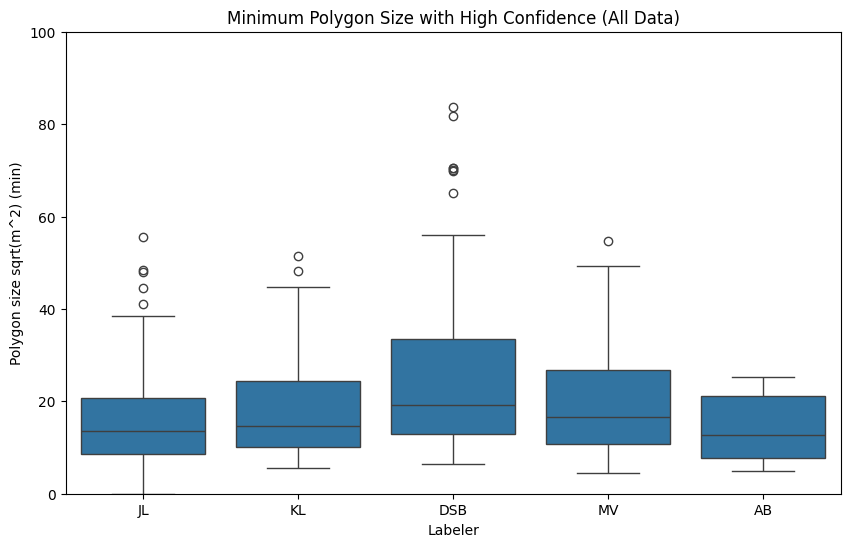

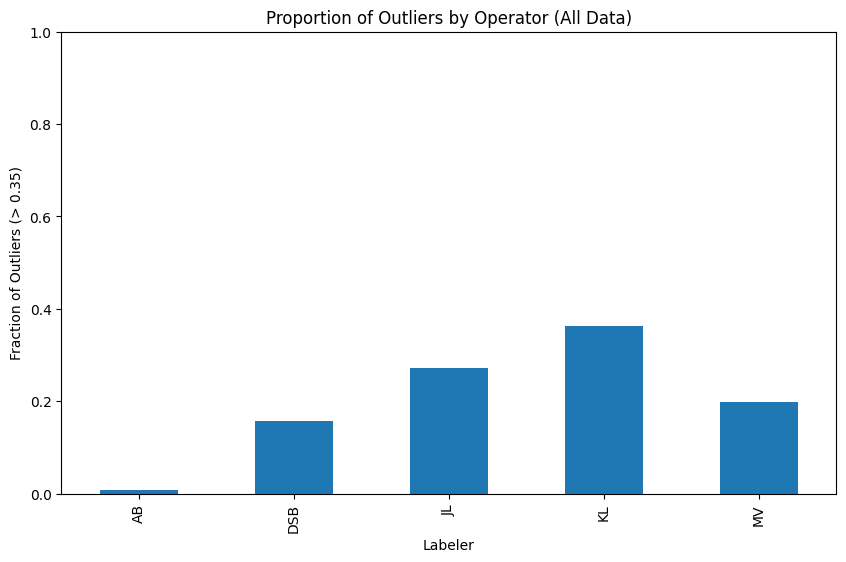

In [6]:
plot_num_images(most_recent_surveys, title="Number of images by operator (divided by number of surveys)", by_survey=True)
plot_irrigation_distribution(most_recent_surveys, title="Irrigation certainty by image")
plot_percent_coverage(most_recent_surveys, "Distribution of Percent Coverage (All Data)", certain_only=False, ymax=.5)
plot_percent_coverage(most_recent_surveys, "Distribution of Percent Coverage with High Certainty (All Data)", certain_only=True, ymax=.2)
plot_polygon_size(most_recent_surveys, "Average Polygon Size (All Data)", certain_only=False, ymax=100)
plot_polygon_size(most_recent_surveys, "Average Polygon Size with High Confidence (All Data)", certain_only=True, ymax=100)
plot_polygon_size(most_recent_surveys, "Minimum Polygon Size (All Data)", stat="min", certain_only=False, ymax=100)
plot_polygon_size(most_recent_surveys, "Minimum Polygon Size with High Confidence (All Data)", stat="min", certain_only=True, ymax=100)
plot_coverage_outliers(most_recent_surveys, title="Proportion of Outliers by Operator (All Data)", threshold=.35, certain_only=False)

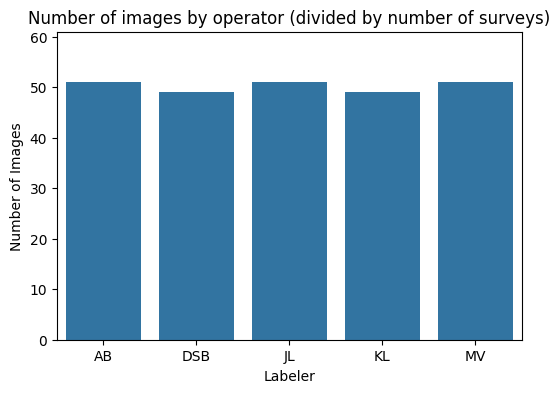

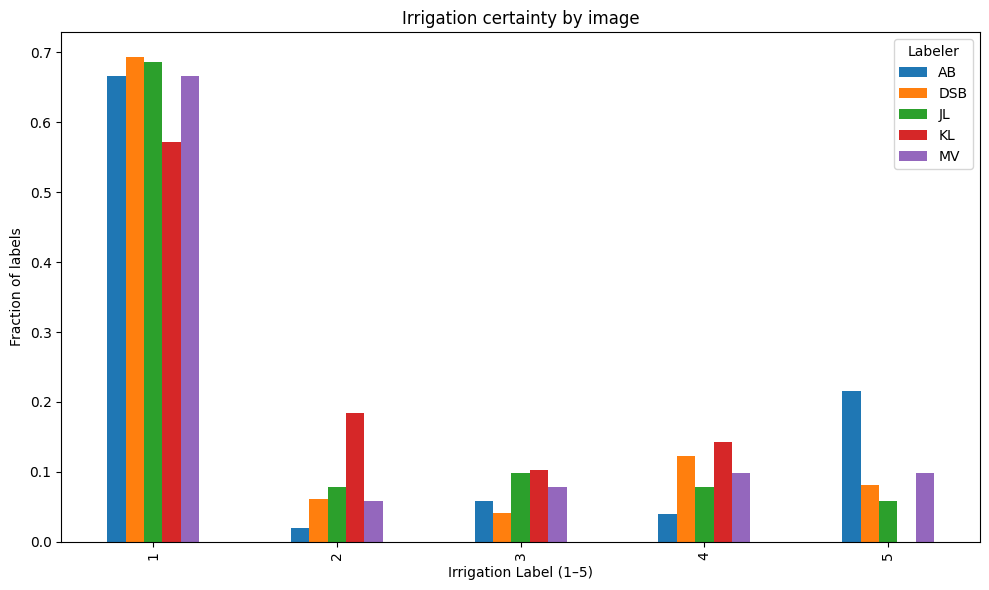

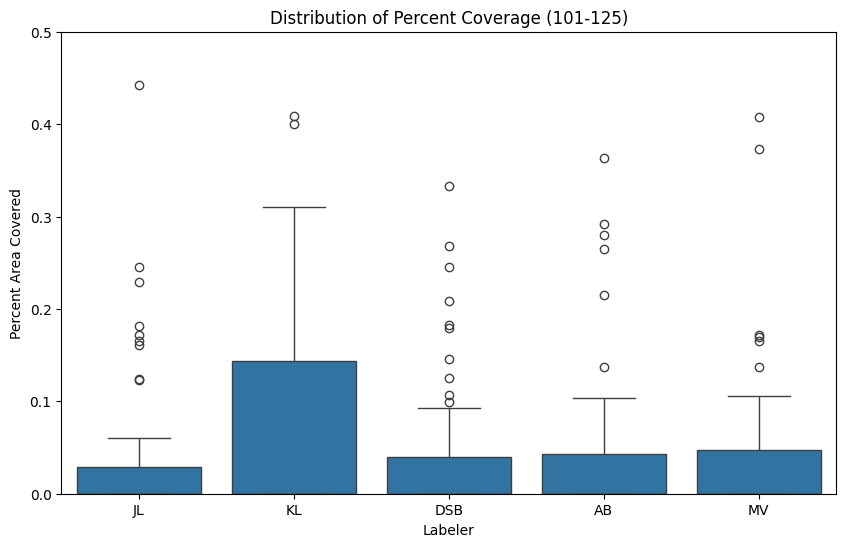

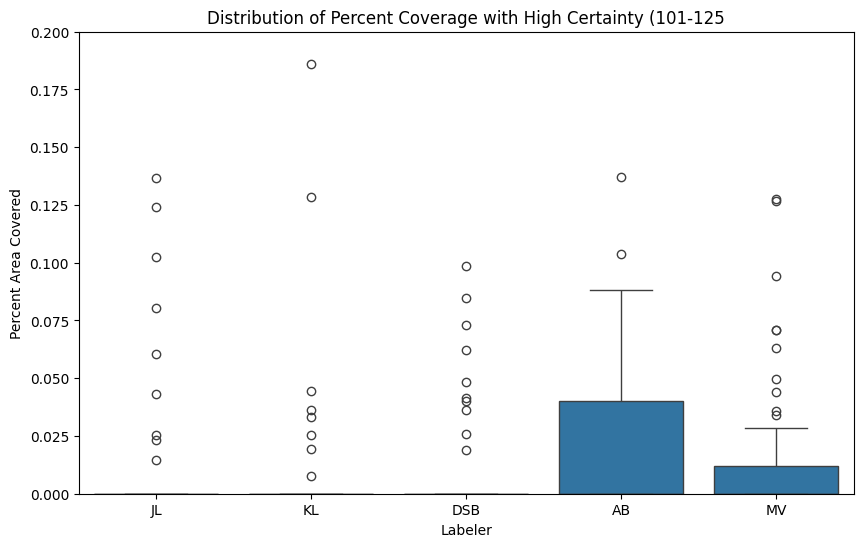

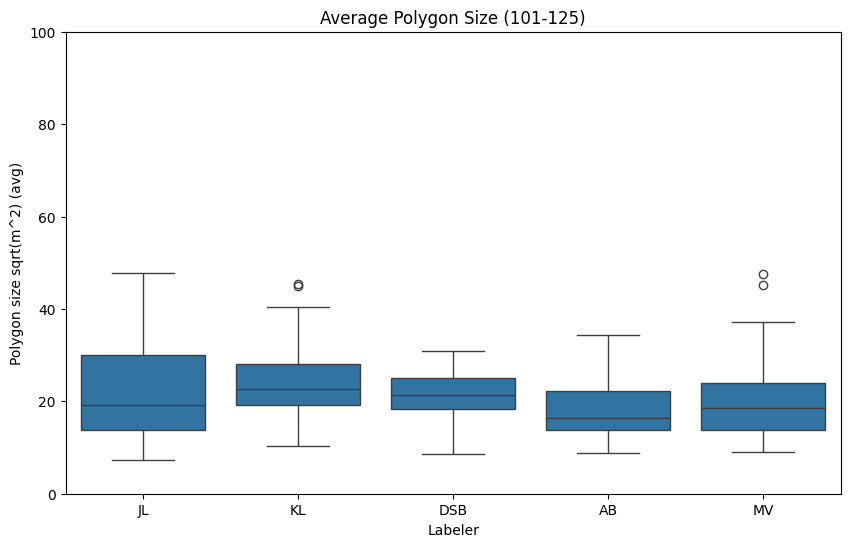

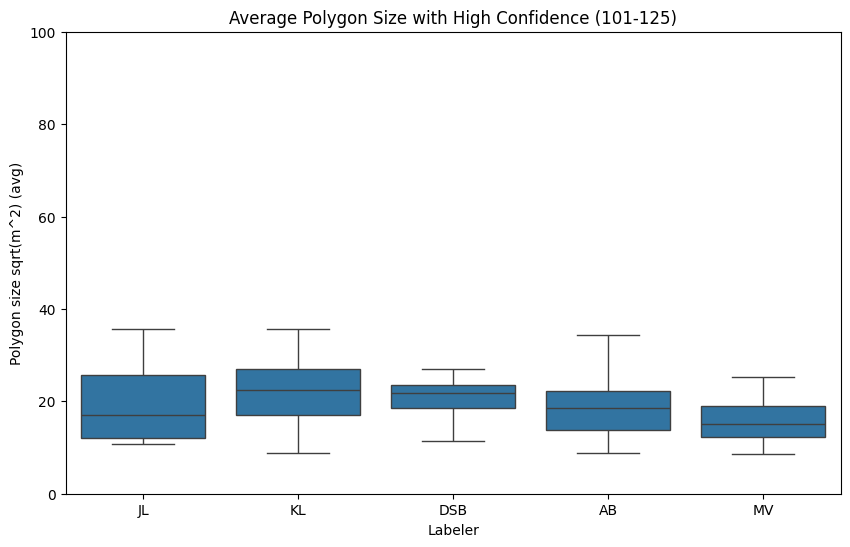

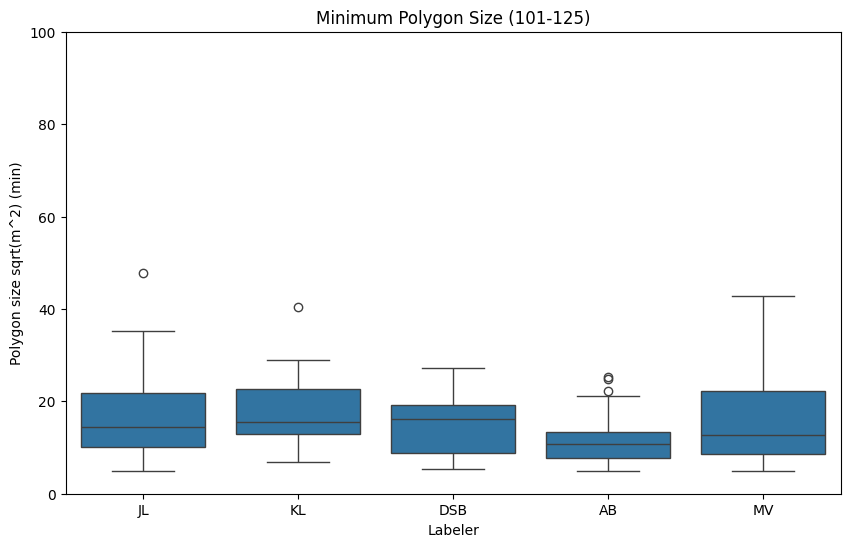

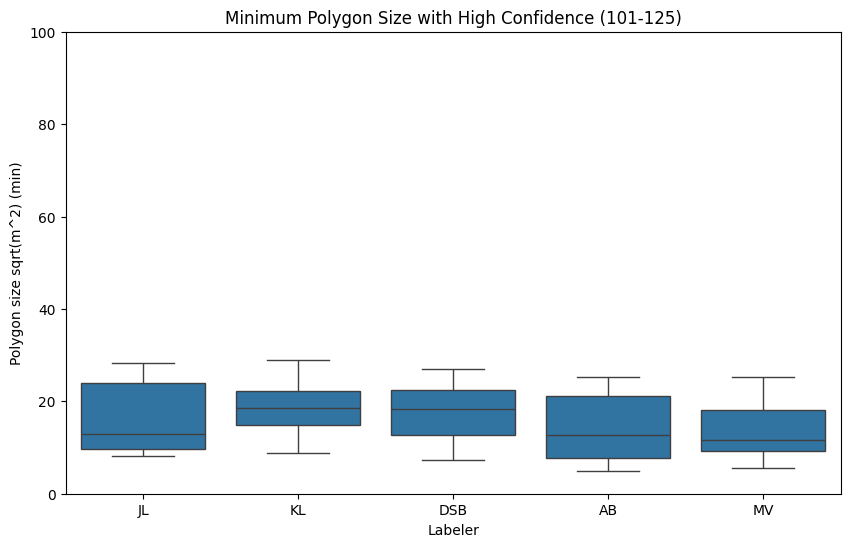

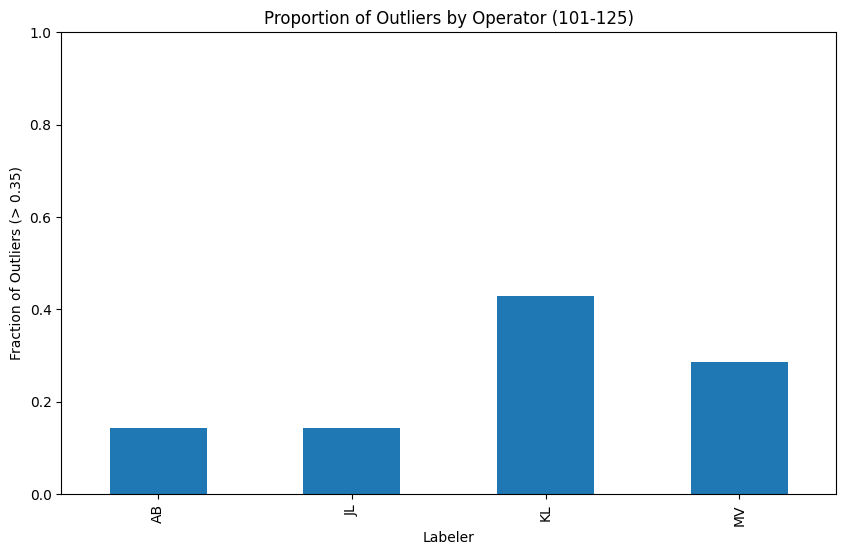

In [7]:
# Same thing but only for the 101 labels we all did

calibration_surveys = most_recent_surveys[most_recent_surveys['source_file'].str.contains('101-125')]

plot_num_images(calibration_surveys, title="Number of images by operator (divided by number of surveys)", by_survey=True)
plot_irrigation_distribution(calibration_surveys, title="Irrigation certainty by image")
plot_percent_coverage(calibration_surveys, "Distribution of Percent Coverage (101-125)", certain_only=False, ymax=.5)
plot_percent_coverage(calibration_surveys, "Distribution of Percent Coverage with High Certainty (101-125", certain_only=True, ymax=.2)
plot_polygon_size(calibration_surveys, "Average Polygon Size (101-125)", certain_only=False, ymax=100)
plot_polygon_size(calibration_surveys, "Average Polygon Size with High Confidence (101-125)", certain_only=True, ymax=100)
plot_polygon_size(calibration_surveys, "Minimum Polygon Size (101-125)", stat="min", certain_only=False, ymax=100)
plot_polygon_size(calibration_surveys, "Minimum Polygon Size with High Confidence (101-125)", stat="min", certain_only=True, ymax=100)
plot_coverage_outliers(calibration_surveys, title="Proportion of Outliers by Operator (101-125)", threshold=.35, certain_only=False)

/Users/annaboser/Documents/GitHub/smallholder-irrigation-dataset/src/utils/figures.py:280: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
/Users/annaboser/Documents/GitHub/smallholder-irrigation-dataset/src/utils/figures.py:281: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image'] = df['site_id'] + '_' + df['date'].dt.strftime('%Y-%m-%d')


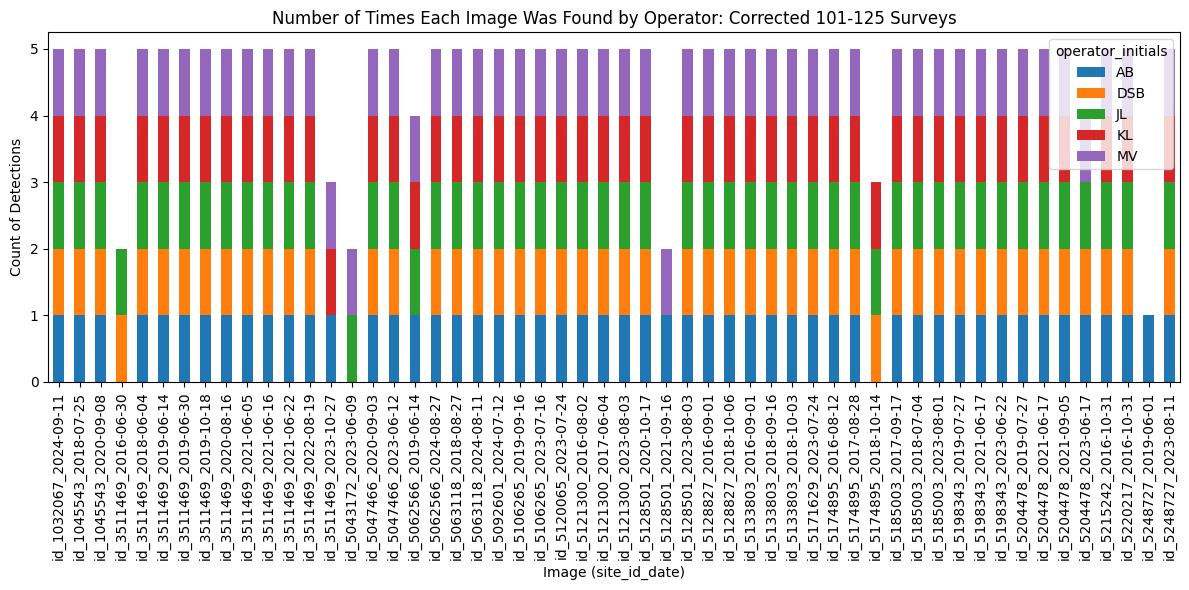

/Users/annaboser/Documents/GitHub/smallholder-irrigation-dataset/src/utils/figures.py:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df[['year','month','day']])
/Users/annaboser/Documents/GitHub/smallholder-irrigation-dataset/src/utils/figures.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image'] = df['site_id'] + '_' + df['date'].dt.strftime('%Y-%m-%d')


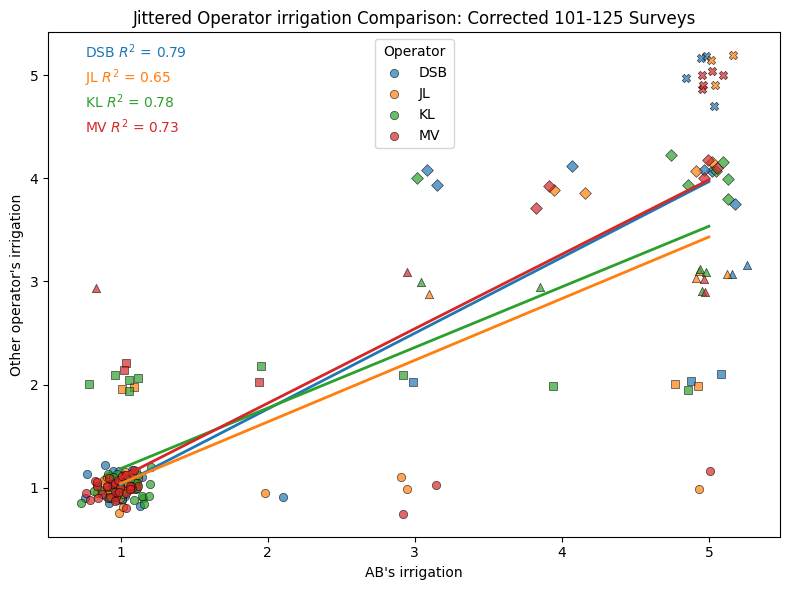

/Users/annaboser/Documents/GitHub/smallholder-irrigation-dataset/src/utils/figures.py:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df[['year','month','day']])
/Users/annaboser/Documents/GitHub/smallholder-irrigation-dataset/src/utils/figures.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image'] = df['site_id'] + '_' + df['date'].dt.strftime('%Y-%m-%d')


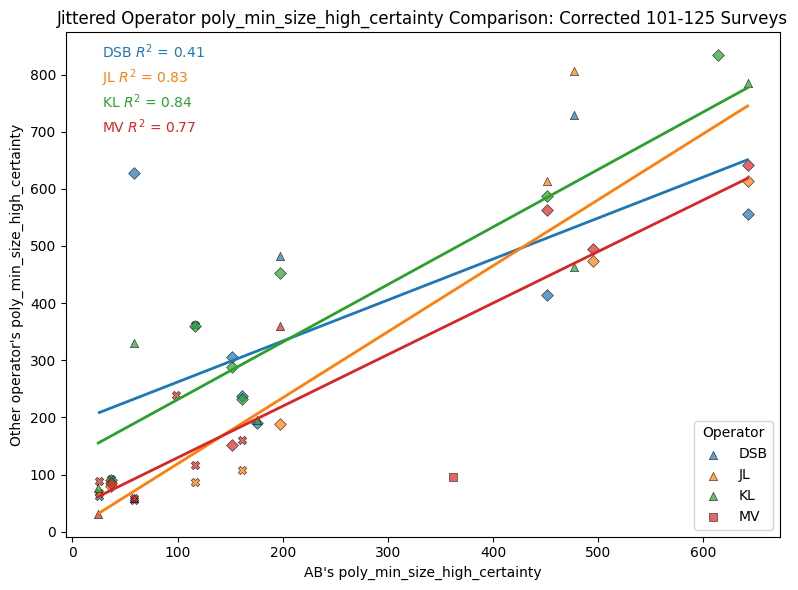

/Users/annaboser/Documents/GitHub/smallholder-irrigation-dataset/src/utils/figures.py:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df[['year','month','day']])
/Users/annaboser/Documents/GitHub/smallholder-irrigation-dataset/src/utils/figures.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image'] = df['site_id'] + '_' + df['date'].dt.strftime('%Y-%m-%d')


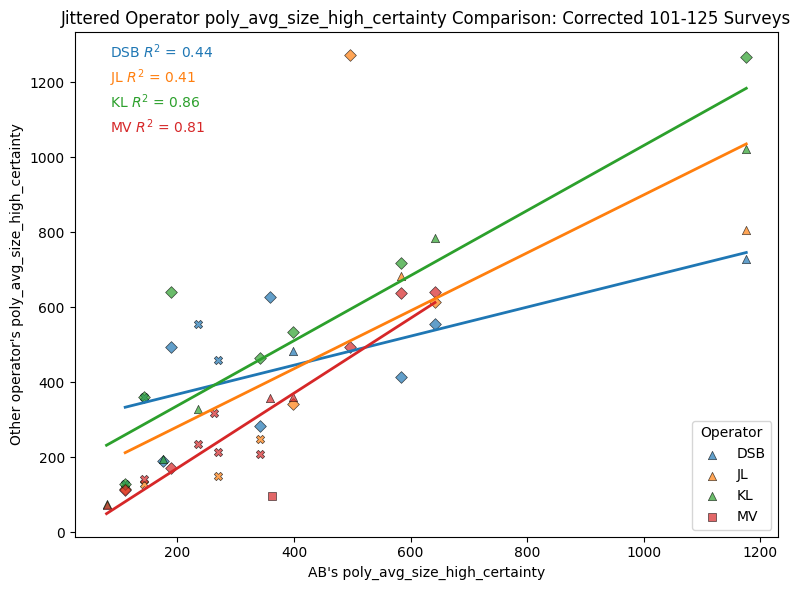

/Users/annaboser/Documents/GitHub/smallholder-irrigation-dataset/src/utils/figures.py:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df[['year','month','day']])
/Users/annaboser/Documents/GitHub/smallholder-irrigation-dataset/src/utils/figures.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image'] = df['site_id'] + '_' + df['date'].dt.strftime('%Y-%m-%d')


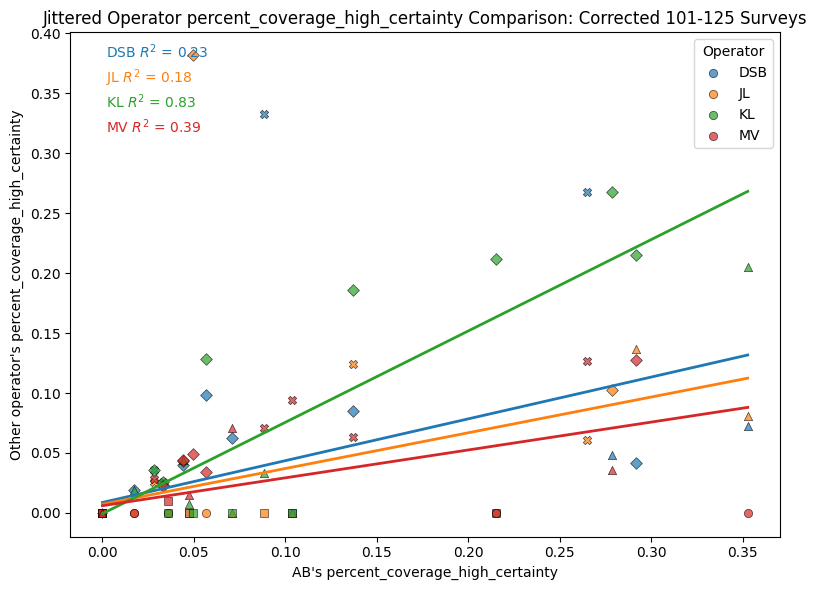

In [8]:
plot_image_counts(calibration_surveys, "Corrected 101-125 Surveys")
compare_to_AB(calibration_surveys, "Corrected 101-125 Surveys", "irrigation", jitter=True)
compare_to_AB(calibration_surveys, "Corrected 101-125 Surveys", "poly_min_size_high_certainty")
compare_to_AB(calibration_surveys, "Corrected 101-125 Surveys", "poly_avg_size_high_certainty")
compare_to_AB(calibration_surveys, "Corrected 101-125 Surveys", "percent_coverage_high_certainty")

/Users/annaboser/Documents/GitHub/smallholder-irrigation-dataset/src/utils/figures.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df[['year','month','day']])
/Users/annaboser/Documents/GitHub/smallholder-irrigation-dataset/src/utils/figures.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image'] = df['site_id'] + '_' + df['date'].dt.strftime('%Y-%m-%d')


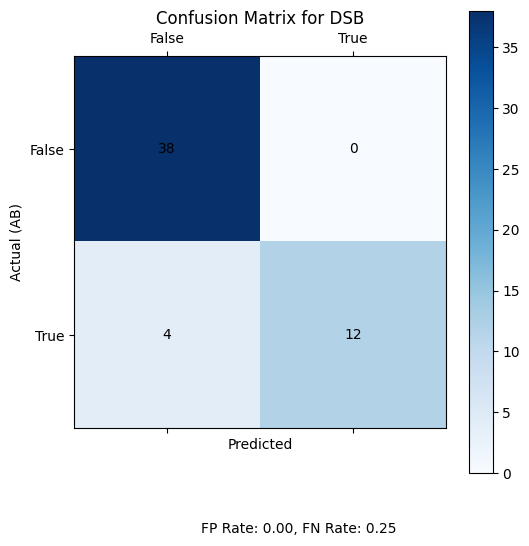

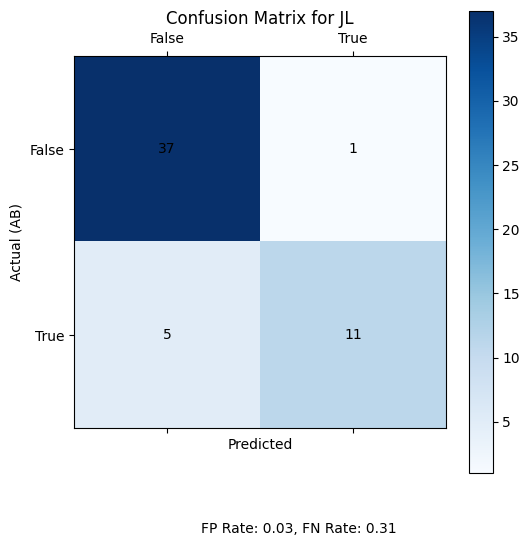

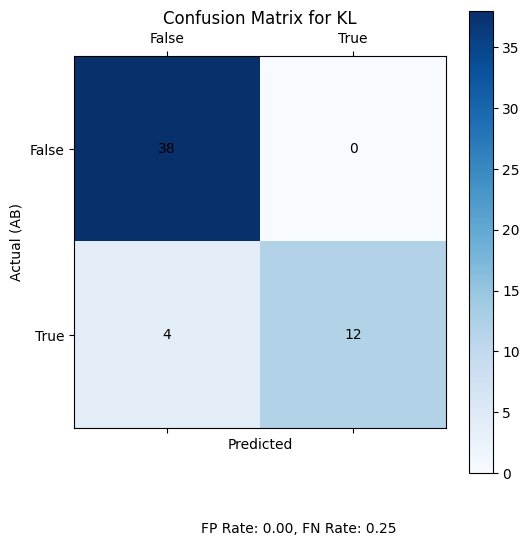

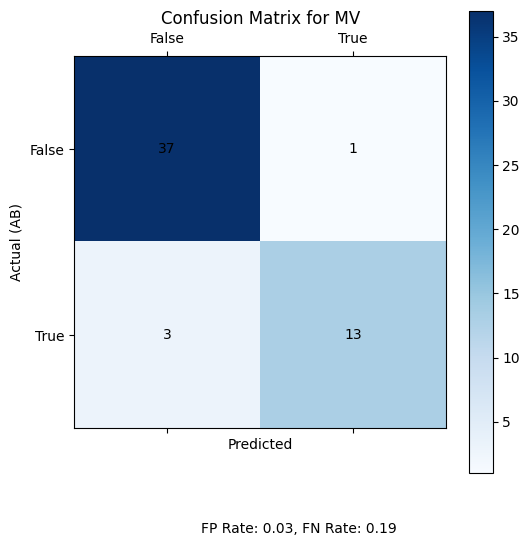

In [9]:

confusion_matrices = confusion_matrix(calibration_surveys, threshold=3)

